In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/glove840b300dtxt/glove.840B.300d.txt
/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/test.csv
/kaggle/input/quora-insincere-questions-classification/train.csv


In [2]:
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn import metrics

from tqdm import tqdm
import math

import seaborn as sns
%matplotlib inline

import gc

In [3]:
train_df = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
print(train_df.shape)
print(test_df.shape)
display(train_df.head())

(1306122, 3)
(375806, 2)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


Check for data imbalance

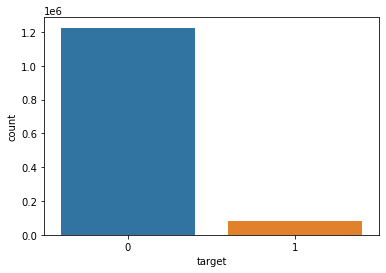

In [4]:
sns.countplot(train_df.target)

Check for missing values

In [5]:
train_df.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

In [6]:
test_df.isna().sum()

qid              0
question_text    0
dtype: int64

Do the following in the next steps:

* Split the train into train and validation sets. We will not do cross valdiation as it is time consuming
* No missing values identified, if any, replace them with 'na'
* Tokenize the `text` column and convert them to vector sequences
* Pad or truncate the sequences as required - truncation happens when sequence length exceeds `max_len` and if less, they will be padded

In [7]:
%%time
# split into train and validation sets

train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=2020)

# some config values for tokenization and vector sequences

max_len = 100        # max number of words in the question that will be used
max_features = 50000 # max number of features or unique words we will use from the entire corpus (the same as number of rows in the embedding matrix)
embed_size = 300     # size of each embedding or word vector

CPU times: user 270 ms, sys: 17.8 ms, total: 288 ms
Wall time: 295 ms


In [8]:
%%time
# substitute missing values in text
train_X = train_df['question_text'].fillna("_na_")
valid_X = valid_df['question_text'].fillna("_na_")
test_X = test_df['question_text'].fillna("_na_")

# tokenize the sentences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = max_features)

# fit on train_X. fit_on_texts() expects a list of text as input
tokenizer.fit_on_texts(train_X.values.tolist())

# use fit_to_sequences method to encode the tokens or words into interger sequences
train_X = tokenizer.texts_to_sequences(train_X.values)
valid_X = tokenizer.texts_to_sequences(valid_X.values)
test_X = tokenizer.texts_to_sequences(test_X.values)

# pad the sentences, according to the max_len
from keras.preprocessing.sequence import pad_sequences

train_X = pad_sequences(train_X, maxlen = max_len)
valid_X = pad_sequences(valid_X, maxlen = max_len)
test_X = pad_sequences(test_X, maxlen = max_len)

# store the target values
train_y = train_df['target'].values
valid_y = valid_df['target'].values

Using TensorFlow backend.


CPU times: user 1min 17s, sys: 864 ms, total: 1min 18s
Wall time: 1min 21s


### Without using any of the trained embeddings provided:
We will learn the embeddings from scratch without using any of the trained embeddings as the first step. For this we will train a Bidirectional GRU model. We will use the CUDA based NN model from Nvidia known as th CuDNNGRU, which is GPU based.

In [9]:
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, CuDNNGRU, Dense, Dropout, LSTM, Conv1D, Activation, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D

from keras import initializers, regularizers, constraints, optimizers, layers

In [10]:
# tensorflow version check
import tensorflow as tf
print('tensor flow version in use: ', tf.__version__)

tensor flow version in use:  2.2.0


Using the CuDNNGRU is not importable as it seems to have been deprecated in recent versions of TF and I keep getting error 'ModuleNotFoundError: No module named 'tensorflow.contrib'', this is because this model is removed in the current version.

The better way is to simply use the GRU and or LSTM as it is, which will default to `CuDNNGRU` and `CuDNNLSTM`, if certain conditions are met. Refer [here](https://stackoverflow.com/questions/60468385/is-there-cudnnlstm-or-cudnngru-alternative-in-tensorflow-2-0)

Refer to other links on how to import a `GRU` model:
1. https://www.tensorflow.org/api_docs/python/tf/compat/v1/keras/layers/CuDNNGRU
2. https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

In [11]:
model = Sequential()
model.add(Embedding(input_dim = max_features, output_dim = embed_size, input_length = max_len)) # input_shape is optional
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          140160    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 15,142,241
Trainable params: 15,142,241
Non-trainable params: 0
__________________________________________

Train the model on the given train split and monitor the metric on the validation set. Run for 2 epochs for now. Changing the epochs, batch_size, model parameters could give a better model

In [12]:
# %%time
# # train the model
# model.fit(train_X, train_y, batch_size=512, epochs =2 , validation_data = (valid_X, valid_y))

In [13]:
# import pickle
# pickle.dump(model, open('bidirectional_gru_keras_no_pretrain_embed.pkl', 'wb'))

*let's looks at the validation sample predictions and decide the best threshold for `F1` score. The actual values are `0` and `1`. Based on threshold, the predictions will vary.*

Here we are learning embeddings and we don't use any of the pretrained embeddings that have been provided along with the data

In [14]:
# prediction_noembed_val_y = model.predict([valid_X], batch_size=1024, verbose=1)

# for thresh in np.arange(0.1, 0.5, 0.01):
#     thresh = np.round(thresh, 2)
#     score = round(metrics.f1_score(valid_y, (prediction_noembed_val_y > thresh).astype(int)),4)
#     print('F1 score at threshold {} is {}'.format(thresh, score))

In [15]:
# # predictions on test(no pretrained embedding in use)
# pred_noembed_y = model.predict([test_X], batch_size=1024, verbose=1)

**Clear memory before going to next step**

In [16]:
del model
gc.collect()

# pause execution for 10s after gc to allow gc to complete
time.sleep(10)

Imported Glove840b300d embeddin file from kaggle

Examine the contents of the embedding file. Each `line` represents a `token` and the correspoding `300D vector embedding`

In [17]:
EMBEDDING_FILE = '../input/glove840b300dtxt/glove.840B.300d.txt'

with open(EMBEDDING_FILE, 'r', encoding='utf8') as fp:
    for i in range(3):
        print(fp.readline())

, -0.082752 0.67204 -0.14987 -0.064983 0.056491 0.40228 0.0027747 -0.3311 -0.30691 2.0817 0.031819 0.013643 0.30265 0.0071297 -0.5819 -0.2774 -0.062254 1.1451 -0.24232 0.1235 -0.12243 0.33152 -0.006162 -0.30541 -0.13057 -0.054601 0.037083 -0.070552 0.5893 -0.30385 0.2898 -0.14653 -0.27052 0.37161 0.32031 -0.29125 0.0052483 -0.13212 -0.052736 0.087349 -0.26668 -0.16897 0.015162 -0.0083746 -0.14871 0.23413 -0.20719 -0.091386 0.40075 -0.17223 0.18145 0.37586 -0.28682 0.37289 -0.16185 0.18008 0.3032 -0.13216 0.18352 0.095759 0.094916 0.008289 0.11761 0.34046 0.03677 -0.29077 0.058303 -0.027814 0.082941 0.1862 -0.031494 0.27985 -0.074412 -0.13762 -0.21866 0.18138 0.040855 -0.113 0.24107 0.3657 -0.27525 -0.05684 0.34872 0.011884 0.14517 -0.71395 0.48497 0.14807 0.62287 0.20599 0.58379 -0.13438 0.40207 0.18311 0.28021 -0.42349 -0.25626 0.17715 -0.54095 0.16596 -0.036058 0.08499 -0.64989 0.075549 -0.28831 0.40626 -0.2802 0.094062 0.32406 0.28437 -0.26341 0.11553 0.071918 -0.47215 -0.18366 -0.3

For details on how what the `*` operator means, refer [here](https://stackoverflow.com/questions/11315010/what-do-and-before-a-variable-name-mean-in-a-function-signature)

Inside a function header:

* `*` unpacks a list or tuple into position arguments.

* `**` unpacks a dictionary into keyword arguments.

In [18]:
# extract the embeddings and the token from the text file
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float16')

In [19]:
# explore how we can use the * operator to unpack the list into a tuple
# do the same for the rest of tokens in each line of the file

with open(EMBEDDING_FILE, 'r', encoding='utf8') as fp:
    firstline = fp.readline()
    secondline = fp.readline()
    print(secondline)
    print(get_coefs(*secondline.split(" ")))

. 0.012001 0.20751 -0.12578 -0.59325 0.12525 0.15975 0.13748 -0.33157 -0.13694 1.7893 -0.47094 0.70434 0.26673 -0.089961 -0.18168 0.067226 0.053347 1.5595 -0.2541 0.038413 -0.01409 0.056774 0.023434 0.024042 0.31703 0.19025 -0.37505 0.035603 0.1181 0.012032 -0.037566 -0.5046 -0.049261 0.092351 0.11031 -0.073062 0.33994 0.28239 0.13413 0.070128 -0.022099 -0.28103 0.49607 -0.48693 -0.090964 -0.1538 -0.38011 -0.014228 -0.19392 -0.11068 -0.014088 -0.17906 0.24509 -0.16878 -0.15351 -0.13808 0.02151 0.13699 0.0068061 -0.14915 -0.38169 0.12727 0.44007 0.32678 -0.46117 0.068687 0.34747 0.18827 -0.31837 0.4447 -0.2095 -0.26987 0.48945 0.15388 0.05295 -0.049831 0.11207 0.14881 -0.37003 0.30777 -0.33865 0.045149 -0.18987 0.26634 -0.26401 -0.47556 0.68381 -0.30653 0.24606 0.31611 -0.071098 0.030417 0.088119 0.045025 0.20125 -0.21618 -0.36371 -0.25948 -0.42398 -0.14305 -0.10208 0.21498 -0.21924 -0.17935 0.21546 0.13801 0.24504 -0.2559 0.054815 0.21307 0.2564 -0.25673 0.17961 -0.47638 -0.25181 -0.00

In [20]:
%%time
with open(EMBEDDING_FILE, 'r', encoding='utf8') as fp:
    for o in fp:
        print(get_coefs(*o.split()))
        break

(',', array([-0.08276 ,  0.672   , -0.1499  , -0.065   ,  0.0565  ,  0.4023  ,
        0.002775, -0.331   , -0.307   ,  2.082   ,  0.03183 ,  0.01364 ,
        0.3027  ,  0.00713 , -0.582   , -0.2773  , -0.06226 ,  1.1455  ,
       -0.2423  ,  0.1235  , -0.12244 ,  0.3315  , -0.00616 , -0.3054  ,
       -0.1306  , -0.0546  ,  0.03708 , -0.07056 ,  0.5894  , -0.304   ,
        0.2898  , -0.1465  , -0.2705  ,  0.3716  ,  0.3203  , -0.2913  ,
        0.00525 , -0.1321  , -0.05273 ,  0.08734 , -0.2666  , -0.169   ,
        0.01516 , -0.00838 , -0.1487  ,  0.2341  , -0.2072  , -0.0914  ,
        0.4006  , -0.1722  ,  0.1814  ,  0.376   , -0.2869  ,  0.3728  ,
       -0.1619  ,  0.18    ,  0.3032  , -0.1322  ,  0.1835  ,  0.09576 ,
        0.0949  ,  0.008286,  0.1176  ,  0.3406  ,  0.03677 , -0.2908  ,
        0.0583  , -0.02782 ,  0.08295 ,  0.1862  , -0.0315  ,  0.2798  ,
       -0.0744  , -0.1376  , -0.2186  ,  0.1814  ,  0.04086 , -0.113   ,
        0.2411  ,  0.3657  , -0.2751  , -0.05

In [21]:
%%time
with open(EMBEDDING_FILE, 'r') as fp:
    embedding_index = dict(get_coefs(*o.split(" ")) for o in fp)

CPU times: user 4min 34s, sys: 5.5 s, total: 4min 39s
Wall time: 4min 40s


 Since all_embeds.std() is coming to 'inf' or Infinity, hard code the values. 
 
 For mean, there is no issue  emb_mean,emb_std = -0.005838499,0.48782197

In [22]:
%%time
print('Size of the embedding index: ', len(embedding_index))

# stack the embedding values to calculate the mean and std for a normal distribution
all_embeds = np.stack(list(embedding_index.values()))
embed_mean = np.mean(all_embeds) # or all_embeds.mean(), all_embeds.std() will do
embed_std = 0.48782197
embed_size = all_embeds.shape[1]
print(embed_mean, embed_std)
print('embedding matrix shape', all_embeds.shape)

del all_embeds

Size of the embedding index:  2196017
-0.00584 0.48782197


NameError: name 'prin' is not defined

Lets look at the tokens from our training data and use the learned glove embeddings to extract the embeddings for those tokens only.
Before extracting, the embeddings are normalized. This is because, in the glove embeddings, there are some tokens in lower and upper case, which has different embeddings, though there are quite similar, while others don't have this. So it is better to normalize them before using the learned embeddings for the training data

In [23]:
%%time
# get the tokens from our training data. Remember the Keras tokenizer has already beeen fit on the train text.

word_index = tokenizer.word_index
# vocab length should be 1 more to account for tokens which has embeddings missing
print('Number of words in the vocabulary is :', len(word_index) +1)

vocab_length = len(word_index)+1

# select minimum of tokens tokenized words from train and max_features we want to learn
nb_words = min(len(word_index), max_features)

''' Use the below when not going to normalize the distribution'''
embedding_matrix = np.zeros((len(word_index)+1, embed_size))

# normalize the distribution fo embeddings and store them in a matrix, the tokens will be added as keys in the next step
embedding_matrix = np.random.normal(embed_mean, embed_std, (nb_words+1, embed_size))

count_found = nb_words
missing_tokens =[]


for word, index in word_index.items():
    if index >= max_features:
        continue
    embedding_vector = embedding_index.get(word) # get the embedding vector for the word
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        count_found -=1
        missing_tokens.append(word)

print('Found embedding for {} words from the embeddings, from a total of {}'.format(count_found, nb_words))
       
print('Number of missing tokens are: ', len(missing_tokens))        
print('Size of the embedding matrix is: ', embedding_matrix.shape)

Number of words in the vocabulary is : 209442
Found embedding for 45959 words from the embeddings, from a total of 50000
Number of missing tokens are:  4041
Size of the embedding matrix is:  (50001, 300)
CPU times: user 847 ms, sys: 6.67 ms, total: 854 ms
Wall time: 870 ms


Now lets define a Neural network model to use the above as inputs.

The embedding layer can be seeded with the GloVe word embedding weights. Finally, we do not want to update the `learned word weights` in this model, therefore we will set the `trainable` attribute for the model to be `False`

In [25]:
model = Sequential()
#model.add(Embedding(input_dim = max_features, output_dim = embed_size, input_length = max_len, weights=[embedding_matrix], trainable=False))
model.add(Embedding(input_dim = max_features+1, output_dim = embed_size, input_length = max_len, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss ='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          15000300  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          140160    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 15,142,541
Trainable params: 142,241
Non-trainable params: 15,000,300
____________________________________

In [26]:
%%time
model.fit(train_X, train_y, batch_size=512, epochs=1, validation_data=[valid_X, valid_y])

Train on 1175509 samples, validate on 130613 samples
Epoch 1/1
1175509/1175509 [==============================] - 1040s 884us/step - loss: 0.1394 - accuracy: 0.9484 - val_loss: 0.1207 - val_accuracy: 0.9525
CPU times: user 25min 58s, sys: 3min 59s, total: 29min 57s
Wall time: 17min 21s


**Prediction using Glove embedding trained NN model**

In [27]:
pred_glove_val_y = model.predict([valid_X], batch_size=1024, verbose=1)

# check the F1_score at different thresholds
for thresh in np.arange(0.1, 0.5, 0.01):
    score = metrics.f1_score(valid_y, (pred_glove_val_y > thresh).astype(int))
    print('F1_score at threshold {} is {}'.format(thresh, round(score, 3)))

130613/130613 [==============================] - 5s 40us/step
F1_score at threshold 0.1 is 0.528
F1_score at threshold 0.11 is 0.536
F1_score at threshold 0.12 is 0.544
F1_score at threshold 0.13 is 0.551
F1_score at threshold 0.13999999999999999 is 0.558
F1_score at threshold 0.14999999999999997 is 0.562
F1_score at threshold 0.15999999999999998 is 0.567
F1_score at threshold 0.16999999999999998 is 0.572
F1_score at threshold 0.17999999999999997 is 0.576
F1_score at threshold 0.18999999999999995 is 0.58
F1_score at threshold 0.19999999999999996 is 0.583
F1_score at threshold 0.20999999999999996 is 0.587
F1_score at threshold 0.21999999999999995 is 0.589
F1_score at threshold 0.22999999999999995 is 0.592
F1_score at threshold 0.23999999999999994 is 0.595
F1_score at threshold 0.24999999999999992 is 0.596
F1_score at threshold 0.2599999999999999 is 0.597
F1_score at threshold 0.2699999999999999 is 0.601
F1_score at threshold 0.2799999999999999 is 0.602
F1_score at threshold 0.2899999999

In [28]:
pred_glove_test_y = model.predict([test_X], batch_size=1024, verbose=1)

375806/375806 [==============================] - 14s 38us/step


In [31]:
del word_index, embedding_index, all_embeds, embedding_matrix, embedding_index, model
gc.collect()
time.sleep(10)

NameError: name 'embedding_index' is not defined